In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #  r_in:1, n_in:28, j_in:1, r_out:3, n_out:28
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        #  r_in:3, n_in:28, r_out:5, n_out:28
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        #  r_in:5, n_in:28, r_out:6, n_out:14
        self.pool1 = nn.MaxPool2d(2, 2)
        #  r_in:6, n_in:14, r_out:10, n_out:14
        self.conv3 = nn.Conv2d(16, 16, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout(0.25)


        #  r_in:10, n_in:14, r_out:14, n_out:14
        self.conv4 = nn.Conv2d(16, 16, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(16)
        #  r_in:14, n_in:14, r_out:16, n_out:7
        self.pool2 = nn.MaxPool2d(2, 2)
        #  r_in:16, n_in:7, r_out:24, n_out:5
        self.conv5 = nn.Conv2d(16, 16, 3)
        self.bn5 = nn.BatchNorm2d(16)


        #  r_in:24, n_in:5, r_out:32, n_out:3
        self.conv6 = nn.Conv2d(16, 32, 3)
        self.bn6 = nn.BatchNorm2d(32)
        #  r_in:32, n_in:3, r_out:32, n_out:3
        self.conv7 = nn.Conv2d(32, 10, 1)
        #  r_in:32, n_in:3, r_out:40, n_out:1
        self.gap = nn.AvgPool2d(3, 3)
        self.flatten = nn.Flatten()


    def forward(self, x):
        # First block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Second block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        # Third block
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))

        # Final convolution
        x = (self.conv7(x))

        # Global average pooling and flatten
        x = self.gap(x)
        x = self.flatten(x)

        # Softmax
        x = F.log_softmax(x, dim=1)

        return x

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
            Conv2d-3           [-1, 16, 28, 28]           2,320
       BatchNorm2d-4           [-1, 16, 28, 28]              32
         MaxPool2d-5           [-1, 16, 14, 14]               0
           Dropout-6           [-1, 16, 14, 14]               0
            Conv2d-7           [-1, 16, 14, 14]           2,320
       BatchNorm2d-8           [-1, 16, 14, 14]              32
            Conv2d-9           [-1, 16, 14, 14]           2,320
      BatchNorm2d-10           [-1, 16, 14, 14]              32
        MaxPool2d-11             [-1, 16, 7, 7]               0
           Conv2d-12             [-1, 16, 5, 5]           2,320
      BatchNorm2d-13             [-1, 16, 5, 5]              32
           Conv2d-14             [-1, 3

In [ ]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


100%|██████████| 9912422/9912422 [00:00<00:00, 82856783.77it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 82293270.26it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26194177.03it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12459469.44it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()
from tqdm import tqdm


def train(model, device, train_loader, optimizer):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate loss
        loss = F.nll_loss(pred, target)
        train_loss+=loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    return (100*correct/processed,train_loss/len(train_loader))


def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (100. * correct / len(test_loader.dataset),test_loss)

In [ ]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}
model = Net().to(device)

# Set up the SGD optimizer with learning rate 0.01 and momentum 0.9
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Set up a learning rate scheduler to adjust the learning rate during training
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1, verbose=True)

# Set the number of epochs for training
num_epochs = 20

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
     # Train the model
    epoch_train_performance = train(model, device, train_loader, optimizer)
    # Evaluate the model on the test set
    epoch_test_performance = test(model, device, test_loader)

    # Append the training and testing accuracy and loss for this epoch to the respective lists
    train_acc.append(epoch_train_performance[0])
    train_losses.append(epoch_train_performance[1])
    test_acc.append(epoch_test_performance[0])
    test_losses.append(epoch_test_performance[1])

    # Update the learning rate scheduler for the next epoch
    scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.1256 Batch_id=468 Accuracy=88.63: 100%|██████████| 469/469 [01:34<00:00,  4.97it/s]


Test set: Average loss: 0.0632, Accuracy: 9852/10000 (98.52%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.0635 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [01:34<00:00,  4.97it/s]


Test set: Average loss: 0.0478, Accuracy: 9860/10000 (98.60%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0452 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [01:33<00:00,  5.02it/s]


Test set: Average loss: 0.0356, Accuracy: 9897/10000 (98.97%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0354 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [01:34<00:00,  4.98it/s]


Test set: Average loss: 0.0290, Accuracy: 9919/10000 (99.19%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0486 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [01:33<00:00,  5.01it/s]


Test set: Average loss: 0.0327, Accuracy: 9900/10000 (99.00%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0574 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [01:33<00:00,  4.99it/s]


Test set: Average loss: 0.0246, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 7


Train: Loss=0.0337 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [01:33<00:00,  4.99it/s]


Test set: Average loss: 0.0206, Accuracy: 9944/10000 (99.44%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 8


Train: Loss=0.0150 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [01:36<00:00,  4.85it/s]


Test set: Average loss: 0.0199, Accuracy: 9945/10000 (99.45%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 9


Train: Loss=0.0247 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [01:34<00:00,  4.97it/s]


Test set: Average loss: 0.0207, Accuracy: 9944/10000 (99.44%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 10


Train: Loss=0.0163 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [01:34<00:00,  4.97it/s]


Test set: Average loss: 0.0200, Accuracy: 9943/10000 (99.43%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 11


Train: Loss=0.0065 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [01:33<00:00,  4.99it/s]


Test set: Average loss: 0.0202, Accuracy: 9940/10000 (99.40%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 12


Train: Loss=0.0395 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [01:34<00:00,  4.96it/s]


Test set: Average loss: 0.0199, Accuracy: 9942/10000 (99.42%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 13


Train: Loss=0.0070 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [01:33<00:00,  5.02it/s]


Test set: Average loss: 0.0199, Accuracy: 9942/10000 (99.42%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 14


Train: Loss=0.0283 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [01:36<00:00,  4.86it/s]


Test set: Average loss: 0.0197, Accuracy: 9947/10000 (99.47%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 15


Train: Loss=0.0353 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [01:33<00:00,  4.99it/s]


Test set: Average loss: 0.0198, Accuracy: 9945/10000 (99.45%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 16


Train: Loss=0.0380 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [01:36<00:00,  4.87it/s]


Test set: Average loss: 0.0200, Accuracy: 9943/10000 (99.43%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 17


Train: Loss=0.0412 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [01:36<00:00,  4.87it/s]


Test set: Average loss: 0.0197, Accuracy: 9946/10000 (99.46%)

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 18


Train: Loss=0.0155 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [01:37<00:00,  4.82it/s]


Test set: Average loss: 0.0202, Accuracy: 9941/10000 (99.41%)

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 19


Train: Loss=0.0266 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [01:32<00:00,  5.08it/s]


Test set: Average loss: 0.0201, Accuracy: 9942/10000 (99.42%)

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 20


Train: Loss=0.0074 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [01:30<00:00,  5.15it/s]


Test set: Average loss: 0.0197, Accuracy: 9942/10000 (99.42%)

Adjusting learning rate of group 0 to 1.0000e-05.


Text(0.5, 1.0, 'Test Accuracy')

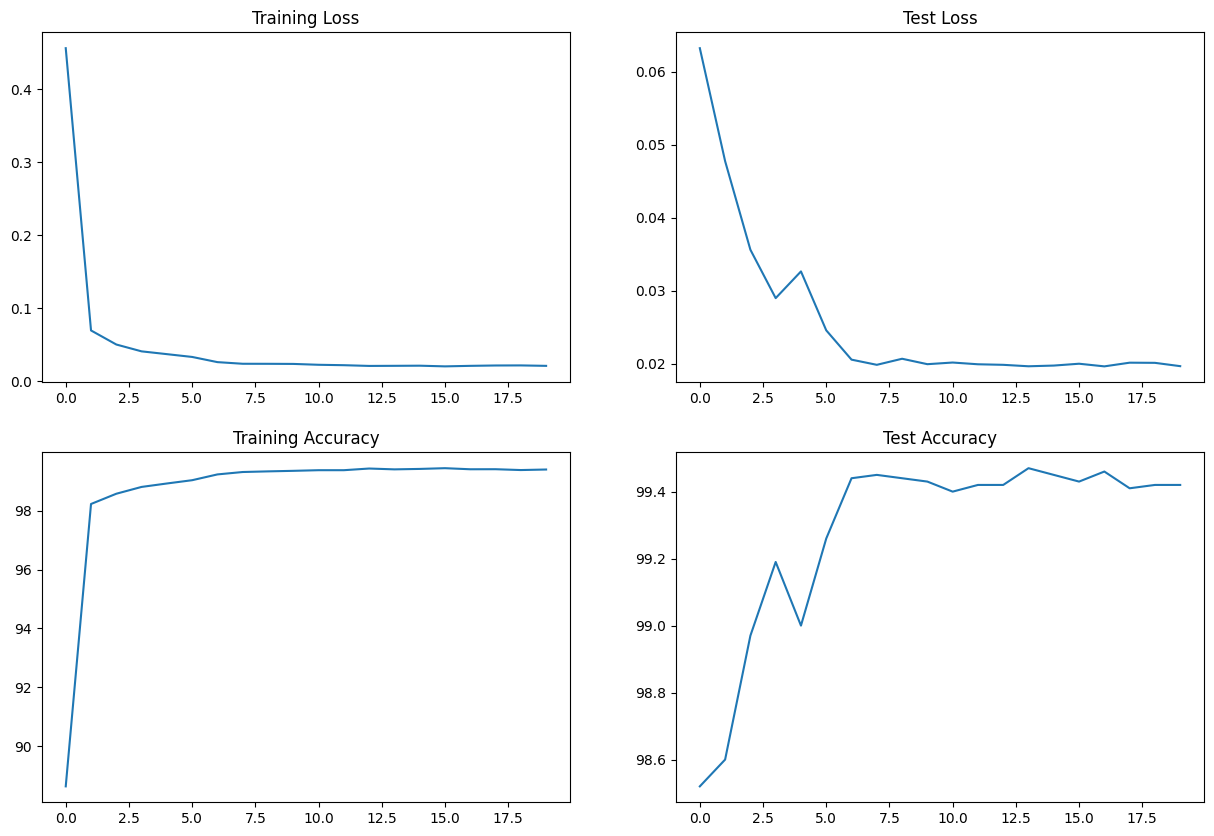

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")